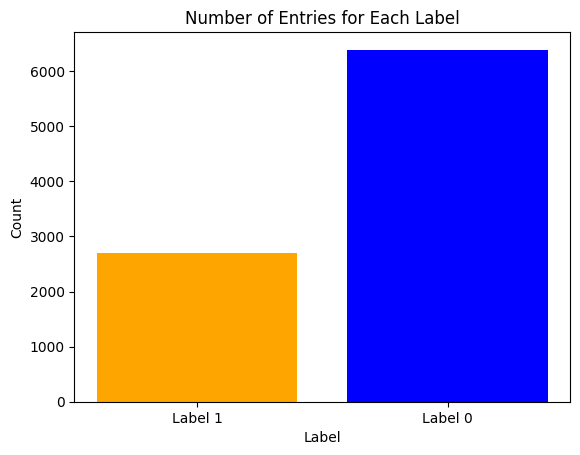

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Combine train and test datasets for tokenization
combined_data = pd.concat([train_data, test_data])
df = combined_data
# Count the occurrences of each label
label_counts = df['label'].value_counts()

# Plot the bar chart
plt.bar(label_counts.index, label_counts.values, color=['blue', 'orange'])
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Number of Entries for Each Label')
plt.xticks(label_counts.index, ['Label 0', 'Label 1'])

# Display the plot
plt.show()

In [2]:
df['label'].value_counts()

1    6388
0    2690
Name: label, dtype: int64

### Using scaled Data input for LSTM model using MinMaxScaler

In [3]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer

# Load the train and test datasets
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Combine train and test datasets for tokenization
combined_data = pd.concat([train_data, test_data])

# Tokenize and pad the sentences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(combined_data['text'])

# Tokenize and pad the train sentences
train_sequences = tokenizer.texts_to_sequences(train_data['text'])
train_padded_sequences = pad_sequences(train_sequences)

# Tokenize and pad the test sentences
test_sequences = tokenizer.texts_to_sequences(test_data['text'])
test_padded_sequences = pad_sequences(test_sequences, maxlen=train_padded_sequences.shape[1])

# Ensure the vocabulary size is the same for both train and test sets
vocab_size = len(tokenizer.word_index) + 1

# Use MinMaxScaler to scale the sequences
scaler = MinMaxScaler()

# Combine sequences for scaling
combined_sequences = tokenizer.texts_to_sequences(combined_data['text'])
combined_padded_sequences = pad_sequences(combined_sequences)
combined_sequences_scaled = scaler.fit_transform(combined_padded_sequences)

# Apply the same scaling to train and test sequences
train_sequences_scaled = combined_sequences_scaled[:len(train_data)]
test_sequences_scaled = combined_sequences_scaled[len(train_data):]

# Pad the scaled sequences
train_padded_sequences_scaled = pad_sequences(train_sequences_scaled)
test_padded_sequences_scaled = pad_sequences(test_sequences_scaled, maxlen=train_padded_sequences_scaled.shape[1])

# Define the neural network
scaled_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64, input_length=train_padded_sequences_scaled.shape[1]),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

scaled_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the scaled_model
scaled_model.fit(train_padded_sequences_scaled, train_data['label'], epochs=5, verbose=2)

Epoch 1/5
268/268 - 14s - loss: 0.6190 - accuracy: 0.7035 - 14s/epoch - 52ms/step
Epoch 2/5
268/268 - 10s - loss: 0.6135 - accuracy: 0.7044 - 10s/epoch - 38ms/step
Epoch 3/5
268/268 - 10s - loss: 0.6108 - accuracy: 0.7044 - 10s/epoch - 38ms/step
Epoch 4/5
268/268 - 9s - loss: 0.6132 - accuracy: 0.7044 - 9s/epoch - 35ms/step
Epoch 5/5
268/268 - 10s - loss: 0.6124 - accuracy: 0.7044 - 10s/epoch - 38ms/step


In [4]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

class Grader:
    def __init__(self, tokenizer, model, train_padded_sequences):
        self.tokenizer = tokenizer
        self.model = model
        self.train_padded_sequences = train_padded_sequences

    def evaluate_sentence(self, sentence):
        input_sequence = pad_sequences(self.tokenizer.texts_to_sequences([sentence]), maxlen=self.train_padded_sequences.shape[1])
        output_likelihood = self.model.predict(input_sequence)[0, 0]
        grammatical_likelihood = 1 - output_likelihood
        return grammatical_likelihood

grader = Grader(tokenizer, scaled_model, train_padded_sequences)

sentence_to_evaluate = "he don't come here no more."
likelihood = grader.evaluate_sentence(sentence_to_evaluate)

print(f"The likelihood that the sentence is grammatically correct: {likelihood}")


1/1 [==============================] - 1s 994ms/step
The likelihood that the sentence is grammatically correct: 0.3241499066352844


In [5]:
from sklearn.metrics import precision_score, recall_score

predictions = scaled_model.predict(test_padded_sequences)
binary_predictions = (predictions > 0.5).astype(int)

# Calculate precision and recall
precision = precision_score(test_data['label'], binary_predictions)
recall = recall_score(test_data['label'], binary_predictions)

print(f'Precision: {precision}')
print(f'Recall: {recall}')

17/17 [==============================] - 0s 10ms/step
Precision: 0.6925996204933587
Recall: 1.0


### Normal LSTM without any modifications to the input

In [6]:
import tensorflow as tf

# Define the neural network
bc_model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=64, input_length=train_padded_sequences.shape[1]),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

bc_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the bc_model
bc_model.fit(train_padded_sequences, train_data['label'], epochs=20, verbose=2)

# Evaluate the bc_model on the test dataset
test_loss, test_accuracy = bc_model.evaluate(test_padded_sequences, test_data['label'])
print(f'Test Accuracy: {test_accuracy}')


Epoch 1/20
268/268 - 14s - loss: 0.6181 - accuracy: 0.7033 - 14s/epoch - 52ms/step
Epoch 2/20
268/268 - 10s - loss: 0.5895 - accuracy: 0.7099 - 10s/epoch - 38ms/step
Epoch 3/20
268/268 - 10s - loss: 0.5152 - accuracy: 0.7454 - 10s/epoch - 38ms/step
Epoch 4/20
268/268 - 10s - loss: 0.4527 - accuracy: 0.7750 - 10s/epoch - 38ms/step
Epoch 5/20
268/268 - 10s - loss: 0.3983 - accuracy: 0.8025 - 10s/epoch - 38ms/step
Epoch 6/20
268/268 - 11s - loss: 0.3556 - accuracy: 0.8213 - 11s/epoch - 40ms/step
Epoch 7/20
268/268 - 9s - loss: 0.3191 - accuracy: 0.8364 - 9s/epoch - 35ms/step
Epoch 8/20
268/268 - 10s - loss: 0.2894 - accuracy: 0.8496 - 10s/epoch - 38ms/step
Epoch 9/20
268/268 - 10s - loss: 0.2652 - accuracy: 0.8564 - 10s/epoch - 38ms/step
Epoch 10/20
268/268 - 10s - loss: 0.2385 - accuracy: 0.8660 - 10s/epoch - 39ms/step
Epoch 11/20
268/268 - 10s - loss: 0.2280 - accuracy: 0.8740 - 10s/epoch - 38ms/step
Epoch 12/20
268/268 - 10s - loss: 0.2126 - accuracy: 0.8827 - 10s/epoch - 35ms/step
Epo

In [7]:
# Evaluate the model
sentence_to_evaluate = "he don't come here no more."
input_sequence = pad_sequences(tokenizer.texts_to_sequences([sentence_to_evaluate]), maxlen=train_padded_sequences.shape[1])

output_likelihood = bc_model.predict(input_sequence)[0, 0]
print(f"The likelihood that the sentence is grammatically correct: {1- output_likelihood}")

1/1 [==============================] - 1s 727ms/step
The likelihood that the sentence is grammatically correct: 1.0907649993896484e-05


In [8]:
grader = Grader(tokenizer, bc_model, train_padded_sequences)

sentence_to_evaluate = "he don't come here no more."
likelihood = grader.evaluate_sentence(sentence_to_evaluate)

print(f"The likelihood that the sentence is grammatically correct: {likelihood}")


1/1 [==============================] - 0s 24ms/step
The likelihood that the sentence is grammatically correct: 1.0907649993896484e-05


In [9]:
from sklearn.metrics import precision_score, recall_score

predictions = bc_model.predict(test_padded_sequences)
binary_predictions = (predictions > 0.5).astype(int)

# Calculate precision and recall
precision = precision_score(test_data['label'], binary_predictions)
recall = recall_score(test_data['label'], binary_predictions)

print(f'Precision: {precision}')
print(f'Recall: {recall}')

17/17 [==============================] - 0s 11ms/step
Precision: 0.7146464646464646
Recall: 0.7753424657534247


In [10]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = bc_model.evaluate(test_padded_sequences_scaled, test_data['label'])
print(f'Test Accuracy: {test_accuracy}')

17/17 [==============================] - 0s 10ms/step - loss: 0.6258 - accuracy: 0.6850
Test Accuracy: 0.6850094795227051


### Using SMOTE to over sample the minority class which is label 0

In [11]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Ensure the vocabulary size is the same for both train and test sets
vocab_size = len(tokenizer.word_index) + 1

# Use MinMaxScaler to scale the sequences
scaler = MinMaxScaler()

# Apply the same scaling to train and test sequences separately
train_sequences_scaled = scaler.fit_transform(train_padded_sequences)
test_sequences_scaled = scaler.transform(test_padded_sequences)

# Apply SMOTE to over-sample the minority class on the training data
oversampler = SMOTE(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(train_sequences_scaled, train_data['label'])

# Define the neural network
SMOTE_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64, input_length=X_resampled.shape[1]),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

SMOTE_model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Train the SMOTE_model
SMOTE_model.fit(X_resampled, y_resampled, epochs=5, verbose=2)

Epoch 1/5
377/377 - 18s - loss: 0.2502 - accuracy: 0.4979 - 18s/epoch - 49ms/step
Epoch 2/5
377/377 - 14s - loss: 0.2501 - accuracy: 0.4936 - 14s/epoch - 37ms/step
Epoch 3/5
377/377 - 14s - loss: 0.2500 - accuracy: 0.4988 - 14s/epoch - 37ms/step
Epoch 4/5
377/377 - 14s - loss: 0.2500 - accuracy: 0.4866 - 14s/epoch - 37ms/step
Epoch 5/5
377/377 - 32s - loss: 0.2500 - accuracy: 0.4987 - 32s/epoch - 85ms/step


In [12]:
grader = Grader(tokenizer, SMOTE_model, train_padded_sequences)

sentence_to_evaluate = "he don't come here no more."
likelihood = grader.evaluate_sentence(sentence_to_evaluate)

print(f"The likelihood that the sentence is grammatically correct: {likelihood}")


1/1 [==============================] - 1s 737ms/step
The likelihood that the sentence is grammatically correct: 0.5003257393836975


In [13]:
from sklearn.metrics import precision_score, recall_score

predictions = SMOTE_model.predict(test_padded_sequences)
binary_predictions = (predictions > 0.5).astype(int)

# Calculate precision and recall
precision = precision_score(test_data['label'], binary_predictions)
recall = recall_score(test_data['label'], binary_predictions)

print(f'Precision: {precision}')
print(f'Recall: {recall}')

17/17 [==============================] - 0s 11ms/step
Precision: 0.0
Recall: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### No changes to the input but using MSE for loss value calculation instead of binary_crossentropy

In [14]:
import tensorflow as tf

# Define the neural network
MSE_model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=64, input_length=train_padded_sequences.shape[1]),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

MSE_model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Train the MSE_model
MSE_model.fit(train_padded_sequences, train_data['label'], epochs=20, verbose=2)

# Evaluate the MSE_model on the test dataset
test_loss, test_accuracy = MSE_model.evaluate(test_padded_sequences, test_data['label'])
print(f'Test Accuracy: {test_accuracy}')


Epoch 1/20
268/268 - 21s - loss: 0.2137 - accuracy: 0.7041 - 21s/epoch - 78ms/step
Epoch 2/20
268/268 - 11s - loss: 0.1965 - accuracy: 0.7124 - 11s/epoch - 40ms/step
Epoch 3/20
268/268 - 16s - loss: 0.1668 - accuracy: 0.7531 - 16s/epoch - 58ms/step
Epoch 4/20
268/268 - 10s - loss: 0.1445 - accuracy: 0.7889 - 10s/epoch - 37ms/step
Epoch 5/20
268/268 - 10s - loss: 0.1298 - accuracy: 0.8158 - 10s/epoch - 39ms/step
Epoch 6/20
268/268 - 10s - loss: 0.1168 - accuracy: 0.8381 - 10s/epoch - 39ms/step
Epoch 7/20
268/268 - 10s - loss: 0.1079 - accuracy: 0.8498 - 10s/epoch - 39ms/step
Epoch 8/20
268/268 - 12s - loss: 0.0986 - accuracy: 0.8583 - 12s/epoch - 46ms/step
Epoch 9/20
268/268 - 18s - loss: 0.0899 - accuracy: 0.8688 - 18s/epoch - 67ms/step
Epoch 10/20
268/268 - 14s - loss: 0.0846 - accuracy: 0.8759 - 14s/epoch - 53ms/step
Epoch 11/20
268/268 - 10s - loss: 0.0769 - accuracy: 0.8861 - 10s/epoch - 37ms/step
Epoch 12/20
268/268 - 14s - loss: 0.0733 - accuracy: 0.8905 - 14s/epoch - 51ms/step
E

In [15]:
grader = Grader(tokenizer, MSE_model, train_padded_sequences)

sentence_to_evaluate = "he don't come here no more."
likelihood = grader.evaluate_sentence(sentence_to_evaluate)

print(f"The likelihood that the sentence is grammatically correct: {likelihood}")


1/1 [==============================] - 1s 951ms/step
The likelihood that the sentence is grammatically correct: 1.3113021850585938e-06


In [16]:
from sklearn.metrics import precision_score, recall_score

predictions = MSE_model.predict(test_padded_sequences)
binary_predictions = (predictions > 0.5).astype(int)

# Calculate precision and recall
precision = precision_score(test_data['label'], binary_predictions)
recall = recall_score(test_data['label'], binary_predictions)

print(f'Precision: {precision}')
print(f'Recall: {recall}')

17/17 [==============================] - 0s 10ms/step
Precision: 0.7064676616915423
Recall: 0.7780821917808219


### Applying Random Over-Sampling to over-sample the minority class (label 0)

In [17]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

# Ensure the vocabulary size is the same for both train and test sets
vocab_size = len(tokenizer.word_index) + 1

# Use MinMaxScaler to scale the sequences
scaler = MinMaxScaler()

# Combine sequences for scaling
combined_sequences = tokenizer.texts_to_sequences(combined_data['text'])
combined_padded_sequences = pad_sequences(combined_sequences)
combined_sequences_scaled = scaler.fit_transform(combined_padded_sequences)

# Apply the same scaling to train and test sequences
train_sequences_scaled = combined_sequences_scaled[:len(train_data)]
test_sequences_scaled = combined_sequences_scaled[len(train_data):]

# Pad the scaled sequences
train_padded_sequences_scaled = pad_sequences(train_sequences_scaled)
test_padded_sequences_scaled = pad_sequences(test_sequences_scaled, maxlen=train_padded_sequences_scaled.shape[1])

# Apply Random Over-Sampling to over-sample the minority class (label 0)
oversampler = RandomOverSampler(sampling_strategy='minority')
X_resampled, y_resampled = oversampler.fit_resample(train_padded_sequences_scaled, train_data['label'])

# Define the neural network
ROS_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64, input_length=X_resampled.shape[1]),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

ROS_model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Train the ROS_model
ROS_model.fit(X_resampled, y_resampled, epochs=5, verbose=2)

Epoch 1/5
377/377 - 18s - loss: 0.2502 - accuracy: 0.4892 - 18s/epoch - 47ms/step
Epoch 2/5
377/377 - 14s - loss: 0.2500 - accuracy: 0.4949 - 14s/epoch - 38ms/step
Epoch 3/5
377/377 - 15s - loss: 0.2500 - accuracy: 0.5017 - 15s/epoch - 40ms/step
Epoch 4/5
377/377 - 14s - loss: 0.2500 - accuracy: 0.4987 - 14s/epoch - 38ms/step
Epoch 5/5
377/377 - 14s - loss: 0.2500 - accuracy: 0.4980 - 14s/epoch - 37ms/step


In [18]:
grader = Grader(tokenizer, ROS_model, train_padded_sequences)

sentence_to_evaluate = "he don't come here no more."
likelihood = grader.evaluate_sentence(sentence_to_evaluate)

print(f"The likelihood that the sentence is grammatically correct: {likelihood}")


1/1 [==============================] - 1s 745ms/step
The likelihood that the sentence is grammatically correct: 0.5004397630691528


In [19]:
from sklearn.metrics import precision_score, recall_score

predictions = ROS_model.predict(test_padded_sequences)
binary_predictions = (predictions > 0.5).astype(int)

# Calculate precision and recall
precision = precision_score(test_data['label'], binary_predictions)
recall = recall_score(test_data['label'], binary_predictions)

print(f'Precision: {precision}')
print(f'Recall: {recall}')

17/17 [==============================] - 0s 10ms/step
Precision: 1.0
Recall: 0.0027397260273972603


### Applying Random Under-Sampling to under-sample the majority class (label 1)

In [20]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split


# Ensure the vocabulary size is the same for both train and test sets
vocab_size = len(tokenizer.word_index) + 1

# Use MinMaxScaler to scale the sequences
scaler = MinMaxScaler()

# Combine sequences for scaling
combined_sequences = tokenizer.texts_to_sequences(combined_data['text'])
combined_padded_sequences = pad_sequences(combined_sequences)
combined_sequences_scaled = scaler.fit_transform(combined_padded_sequences)

# Apply the same scaling to train and test sequences
train_sequences_scaled = combined_sequences_scaled[:len(train_data)]
test_sequences_scaled = combined_sequences_scaled[len(train_data):]

# Pad the scaled sequences
train_padded_sequences_scaled = pad_sequences(train_sequences_scaled)
test_padded_sequences_scaled = pad_sequences(test_sequences_scaled, maxlen=train_padded_sequences_scaled.shape[1])

# Apply Random Under-Sampling to under-sample the majority class (label 1)
undersampler = RandomUnderSampler(sampling_strategy='majority')
X_resampled, y_resampled = undersampler.fit_resample(train_padded_sequences_scaled, train_data['label'])

# Define the neural network
RUS_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64, input_length=X_resampled.shape[1]),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

RUS_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the RUS_model
RUS_model.fit(X_resampled, y_resampled, epochs=5, verbose=2)


Epoch 1/5
158/158 - 9s - loss: 0.6940 - accuracy: 0.4968 - 9s/epoch - 56ms/step
Epoch 2/5
158/158 - 5s - loss: 0.6934 - accuracy: 0.5063 - 5s/epoch - 30ms/step
Epoch 3/5
158/158 - 6s - loss: 0.6935 - accuracy: 0.5061 - 6s/epoch - 35ms/step
Epoch 4/5
158/158 - 5s - loss: 0.6933 - accuracy: 0.5059 - 5s/epoch - 30ms/step
Epoch 5/5
158/158 - 6s - loss: 0.6933 - accuracy: 0.5018 - 6s/epoch - 39ms/step


In [21]:
grader = Grader(tokenizer, RUS_model, train_padded_sequences)

sentence_to_evaluate = "he don't come here no more."
likelihood = grader.evaluate_sentence(sentence_to_evaluate)

print(f"The likelihood that the sentence is grammatically correct: {likelihood}")


1/1 [==============================] - 1s 744ms/step
The likelihood that the sentence is grammatically correct: 0.5001298785209656


In [22]:
from sklearn.metrics import precision_score, recall_score

predictions = RUS_model.predict(test_padded_sequences)
binary_predictions = (predictions > 0.5).astype(int)

# Calculate precision and recall
precision = precision_score(test_data['label'], binary_predictions)
recall = recall_score(test_data['label'], binary_predictions)

print(f'Precision: {precision}')
print(f'Recall: {recall}')

17/17 [==============================] - 0s 11ms/step
Precision: 0.69375
Recall: 0.9123287671232877


# As evident from the results, based on playing around with the grader class the models perform better when the input data is left unscaled, showcasing superior outcomes compared to instances where input data undergoes scaling or balancing. However, based on precision and recall, the output of the scaled data using minmaxscaler showed superior results.

In [33]:
models = {
    "RUS_model": RUS_model,
    "ROS_model": ROS_model,
    "MSE_model": MSE_model,
    "SMOTE_model": SMOTE_model,
    "bc_model": bc_model,
    "scaled_model": scaled_model
}

sentence_to_evaluate = "he don't come here no more."

for model_name, model in models.items():
    grader = Grader(tokenizer, model, train_padded_sequences)
    likelihood = grader.evaluate_sentence(sentence_to_evaluate)
    print(f"based on {model_name} the likelihood that the sentence is grammatically correct: {likelihood}")


1/1 [==============================] - 0s 33ms/step
based on RUS_model the likelihood that the sentence is grammatically correct: 0.5001298785209656
1/1 [==============================] - 0s 43ms/step
based on ROS_model the likelihood that the sentence is grammatically correct: 0.5004397630691528
1/1 [==============================] - 0s 33ms/step
based on MSE_model the likelihood that the sentence is grammatically correct: 1.3113021850585938e-06
1/1 [==============================] - 0s 36ms/step
based on SMOTE_model the likelihood that the sentence is grammatically correct: 0.5003257393836975
1/1 [==============================] - 0s 35ms/step
based on bc_model the likelihood that the sentence is grammatically correct: 1.0907649993896484e-05
1/1 [==============================] - 0s 36ms/step
based on scaled_model the likelihood that the sentence is grammatically correct: 0.3241499066352844


In [34]:
models = {
    "RUS_model": RUS_model,
    "ROS_model": ROS_model,
    "MSE_model": MSE_model,
    "SMOTE_model": SMOTE_model,
    "bc_model": bc_model,
    "scaled_model": scaled_model
}

sentence_to_evaluate = "he doesn't come here any more."

for model_name, model in models.items():
    grader = Grader(tokenizer, model, train_padded_sequences)
    likelihood = grader.evaluate_sentence(sentence_to_evaluate)
    print(f"based on {model_name} the likelihood that the sentence is grammatically correct: {likelihood}")


1/1 [==============================] - 0s 51ms/step
based on RUS_model the likelihood that the sentence is grammatically correct: 0.5001730918884277
1/1 [==============================] - 0s 38ms/step
based on ROS_model the likelihood that the sentence is grammatically correct: 0.5004723072052002
1/1 [==============================] - 0s 38ms/step
based on MSE_model the likelihood that the sentence is grammatically correct: 0.9999995941060433
1/1 [==============================] - 0s 38ms/step
based on SMOTE_model the likelihood that the sentence is grammatically correct: 0.5004700720310211
1/1 [==============================] - 0s 36ms/step
based on bc_model the likelihood that the sentence is grammatically correct: 0.999999981634323
1/1 [==============================] - 0s 33ms/step
based on scaled_model the likelihood that the sentence is grammatically correct: 0.3241214156150818


# To improve the performance of the LSTM model, I woul consider the following methods:

## Experiment with Model Architecture:

- I would adjust the number of LSTM layers and units to see if a deeper or wider network improves performance.
- I would also try different activation functions in the Dense layers.
- Or I would consider using bidirectional LSTM layers to capture information from both past and future sequences.

## Embedding Layer Parameters:

- I would experiment with different values for the `output_dim` parameter in the Embedding layer.
- I would tune the `input_length` parameter based on the average length of the input sequences.

## Adjust Dropout Rate:

- The dropout rate in the Dropout layer can be adjusted.  I would experiment with different rates to prevent overfitting.

## Learning Rate and Optimizer:

- Adjusting the learning rate of the optimizer (adam in this case) might be helpfull. A smaller learning rate might help in convergence.
- Experiment with different optimizers, such as RMSprop or SGD.


## Sequence Padding:

- Experimenting with different padding strategies might be helpful. I would try pre-padding or post-padding and observe the impact on model performance.

## Regularization Techniques:

- I would consider adding L2 regularization to the LSTM and Dense layers to prevent overfitting.
- I would experiment with different dropout rates or try other regularization techniques.

## Hyperparameter Tuning:

- I would use techniques like grid search or random search to find the optimal combination of hyperparameters.


## Increase Training Data:

- I would try to increase the size of the training dataset to provide the model with more diverse examples.

If I had more time I would monitor the model's performance after each modification using mlflow and keep track of changes that positively impact performance. It's often beneficial to iteratively experiment and fine-tune to achieve the best results.